<a href="https://colab.research.google.com/github/Cristie-Lima/FruitsVeggies_ML_Aplicada1/blob/main/Projeto_Final_FruitsVeggies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Projeto Final – Classificação de Frutas, Legumes e Verduras (V2.1)**  
**Base teórica:** Kelleher, John D.; Mac Namee, Brian; D’Arcy, Aoife (2020). *Fundamentals of Machine Learning for Predictive Data Analytics (2nd ed.).*

> **Equipe:** A. Cristiane R. Lima; Claudio Sampaio;

> [parece que Felipe Botero entrou em outro grupo;

> José Henrique Cavalcante apresentou hoje dia 11.out (sabado) ao Prof. Fábio]




## Sumário
0. Introdução e formulação do problema  
1. Ingestão de dados (três arquivos ZIP) e organização das pastas  
1.1 Criação das subpastas e verificação dos arquivos ZIP  
1.2 Estrutura esperada do diretório após a extração  
1.3 Descompactação recursiva e organização automática  
1.4 Diagnóstico da estrutura e verificação de pastas de classes  
1.5 Detecção automática das raízes de classes e contagem de imagens  
2. Preparação e engenharia de atributos (*feature engineering*)  
3. Modelagem conforme Plano de Ensino (KNN, Árvore, Regressão Logística, Random Forest, Bagging, Boosting) + MLP

    **>> Professor sugeriu focar no MLP, kNN, Random Forest pois são os mais adequados para Classificar Imagens; Equipe: fazer double-checking se embedding está sendo aplicado apropriadamente**
4. Avaliação e *benchmarking* (matriz de confusão, métricas, *cross-validation* estratificada)  
5. Empacotamento do melhor modelo e *stub* de aplicativo Streamlit  
6. Conclusões, *trade-offs* (compensações) e trabalhos futuros  
7. Referências



## 0. Introdução e formulação do problema

Observou-se que o objetivo consiste em **classificar imagens** de frutas, legumes e verduras em suas respectivas categorias, utilizando modelos de **aprendizado supervisionado**. Pretende-se fundamentar cada etapa no arcabouço proposto por Kelleher (2ª ed.), contemplando definição do problema, preparação dos dados, modelagem, avaliação e implantação (*deployment*) simplificada via aplicativo.

**Pergunta de pesquisa:** É possível treinar um modelo supervisionado que classifique corretamente, a partir de **atributos extraídos de imagens** (*image features*), as classes de interesse?

**Tipo de tarefa:** Classificação **multiclasse**.

**Objetivo prático:** Disponibilizar um **aplicativo interativo** (Streamlit) que receba uma imagem e retorne a predição do modelo.


In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Pasta no Google Drive:

> Pode-se adaptar para usar direto na content, mas sempre será perdida a estrutura descompactada de arquivos; por isto, optou-se por criar no drive pessoal uma vez só; _**então só basta executar uma vez o item 1.1**_

In [2]:
# @title Chave para pular (SKIP = 1) ou não (SKIP = 0) a Extração de Imagens em Subpastas (Seção 1.1)
# 0: NÃO PULAR, para extrair sempre que estiver configurado SKIP=0
# 1: PULAR, se já houver extraído para o Google Drive pessoal

SKIP = 1


import os, zipfile, glob

BASE_DIR = "/content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies"
SUBFOLDERS = ["validation", "test", "train"]

TRAIN_ZIP = "/content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/train.zip"
TRAIN_DIR = "/content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/train"




## 1. Ingestão de dados (três arquivos ZIP) e organização das pastas

**_Obs._: Como está sendo feito cópia no drive pessoal relativo MyDrive, não há necessidade de re-executar para descompactar.**

## 1.1 Criação das subpastas e verificação dos arquivos ZIP

Deve-se salvar os três arquivos `train.zip`, `validation.zip` e `test.zip` na pasta **`data_FruitsVegs`** da pasta **`/content/drive/MyDrive/`** do Google Colab.  
Em seguida, criam-se automaticamente as subpastas correspondentes (`train/`, `validation/` e `test/`) que irão conter os arquivos descompactados, garantindo a estrutura hierárquica adequada para a detecção de classes.


In [3]:
# @title Descompactação de validation.zip e test.zip
#SKIP = 1
if not SKIP:
  import os, zipfile, glob

  def unzip_quick(zip_path, dest_path):
      if not os.path.exists(zip_path):
          print(f"⚠️ Arquivo ausente: {zip_path}; por gentileza, fazer o 'upload' do arquivo para a respectiva pasta")
          return
      os.makedirs(dest_path, exist_ok=True)
      print(f"📦 Extraindo {os.path.basename(zip_path)} → {dest_path}")
      with zipfile.ZipFile(zip_path, 'r') as zip_ref:
          zip_ref.extractall(dest_path)
      print(f"✓ Extração concluída: {len(glob.glob(os.path.join(dest_path, '**', '*.*'), recursive=True))} arquivos.")

  for sub in SUBFOLDERS:
      zip_file = os.path.join(BASE_DIR, f"{sub}.zip")
      dest = os.path.join(BASE_DIR, sub)
      unzip_quick(zip_file, dest)

In [4]:
# @title Descompactação segura de train.zip (streaming e progressiva)
#SKIP = 1
if not SKIP:
  import zipfile, os
  from tqdm import tqdm  # barra de progresso

  if not os.path.exists(TRAIN_ZIP):
      print("⚠️ train.zip não encontrado.")
  else:
      os.makedirs(TRAIN_DIR, exist_ok=True)
      with zipfile.ZipFile(TRAIN_ZIP, 'r') as zip_ref:
          files = zip_ref.namelist()
          print(f"📦 Extraindo {len(files)} arquivos de train.zip para {TRAIN_DIR} ...")
          for f in tqdm(files, desc="Extraindo", ncols=100):
              try:
                  zip_ref.extract(f, TRAIN_DIR)
              except Exception as e:
                  print("Erro ao extrair:", f, e)
      print("✓ Descompactação de train.zip concluída.")



## 1.2 Estrutura esperada do diretório após a extração

Após a descompactação, a estrutura de diretórios deve seguir o formato abaixo, onde cada subpasta representa uma classe de frutas ou vegetais. O nome da subpasta corresponde ao **rótulo da classe** (label) utilizado no treinamento e avaliação.

```
/content/data_FruitsVegs/
├── train/
│   ├── Apple/
│   ├── Banana/
│   ├── Carrot/
│   └── ...
├── validation/
│   ├── Apple/
│   ├── Banana/
│   ├── Carrot/
│   └── ...
└── test/
    ├── Apple/
    ├── Banana/
    ├── Carrot/
    └── ...
```



### 1.3 Diagnóstico da estrutura e verificação de pastas de classes

Após a extração, realiza-se uma inspeção da árvore de diretórios para confirmar a presença das subpastas de classes (ex.: `Apple`, `Banana`, `Carrot`, etc.) em cada conjunto (`train`, `validation`, `test`). Esse diagnóstico confirma que os dados estão prontos para extração de atributos (*feature extraction*).


In [5]:

# @title Diagnóstico da estrutura (visualização parcial)
import pathlib

def print_tree(root, max_depth=2, prefix=""):
    root = pathlib.Path(root)
    if max_depth < 0:
        return
    entries = sorted(list(root.iterdir()))
    for e in entries[:60]:
        print(prefix + ("📁 " if e.is_dir() else "📄 ") + e.name)
        if e.is_dir():
            print_tree(e, max_depth - 1, prefix + "   ")

print("=== Estrutura parcial de", BASE_DIR, "===")
print_tree(BASE_DIR, max_depth=2)


=== Estrutura parcial de /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies ===
📁 .ipynb_checkpoints
📁 models
   📄 best_model.joblib
   📄 scaler.joblib
📁 test
   📁 apple
      📄 Image_1.jpg
      📄 Image_10.jpg
      📄 Image_2.jpg
      📄 Image_3.jpg
      📄 Image_4.jpg
      📄 Image_5.jpg
      📄 Image_6.JPG
      📄 Image_7.jpg
      📄 Image_8.jpg
      📄 Image_9.jpg
   📁 banana
      📄 Image_1.jpg
      📄 Image_10.jpg
      📄 Image_2.jpg
      📄 Image_3.jpg
      📄 Image_4.jpg
      📄 Image_5.jpg
      📄 Image_6.jpg
      📄 Image_8.jpg
      📄 Image_9.jpg
   📁 beetroot
      📄 Image_1.jpg
      📄 Image_10.jpg
      📄 Image_2.jpg
      📄 Image_3.jpg
      📄 Image_4.jpg
      📄 Image_5.jpg
      📄 Image_6.jpg
      📄 Image_7.jpg
      📄 Image_8.jpg
      📄 Image_9.jpg
   📁 bell pepper
      📄 Image_1.jpg
      📄 Image_10.jpg
      📄 Image_2.jpg
      📄 Image_3.jpeg
      📄 Image_4.jpg
      📄 Image_5.jpg
      📄 Image_6.jpg
      📄 Image_7.jpg
      📄 Image_8.jpg
      📄 Image_9


### 1.4 Detecção automática das raízes de classes e contagem de imagens

Implementa-se um método de **detecção automática da raiz de classes**, que identifica onde estão as pastas correspondentes aos rótulos (labels). Em seguida, realiza-se a contagem do total de imagens em cada conjunto (`train`, `validation`, `test`).


In [6]:

# @title Detecção automática das raízes de classes e contagem de imagens
import os, glob

IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp")

def find_class_root(root):
    best, best_score = None, -1
    for p, dirs, files in os.walk(root):
        subdirs = [os.path.join(p, d) for d in dirs]
        score = 0
        for sd in subdirs:
            imgs = glob.glob(os.path.join(sd, "*"))
            if any(str(x).lower().endswith(IMG_EXTS) for x in imgs):
                score += 1
        if score >= 3 and score > best_score:
            best = p
            best_score = score
    return best

roots = {}
for split in SUBFOLDERS:
    cand = find_class_root(os.path.join(BASE_DIR, split))
    roots[split] = cand if cand else None
    print(f"📂 Raiz detectada para {split}: {roots[split]}")

def list_images(root):
    if not root or not os.path.isdir(root):
        return []
    return [p for p in glob.glob(os.path.join(root, '**', '*'), recursive=True)
            if p.lower().endswith(IMG_EXTS)]

imgs = {split: list_images(roots[split]) for split in roots}

for split, lst in imgs.items():
    print(f"{split}: {len(lst)} imagens")
    if lst:
        print("Exemplo:", lst[0])


📂 Raiz detectada para validation: /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/validation
📂 Raiz detectada para test: /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/test
📂 Raiz detectada para train: /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/train
validation: 351 imagens
Exemplo: /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/validation/apple/Image_1.jpg
test: 359 imagens
Exemplo: /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/test/apple/Image_1.jpg
train: 3115 imagens
Exemplo: /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/train/kiwi/Image_32.jpg



## 2. Preparação e engenharia de atributos (*feature engineering*)

Foram extraídos **atributos de cor** (média RGB) e **descritores de textura/forma** via **HOG (Histogram of Oriented Gradients – histograma de gradientes orientados)**. Em seguida, aplicou-se **normalização** (*scaling*).


In [7]:

# @title Extração de atributos (RGB + HOG) e preparação dos conjuntos (Duração: ~7min)
import cv2, numpy as np, os
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def read_image(path, size=(128,128)):
    img = cv2.imread(path)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size)
    return img

def rgb_mean_feature(img):
    return img.mean(axis=(0,1))

def hog_feature(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    feat = hog(
        gray, orientations=9,
        pixels_per_cell=(8,8),
        cells_per_block=(2,2),
        block_norm='L2-Hys', transform_sqrt=True, feature_vector=True
    )
    return feat

def parent_label(p):
    return os.path.basename(os.path.dirname(p))

def build_Xy(file_list):
    X_rgb, X_hog, y = [], [], []
    for p in file_list:
        img = read_image(p)
        if img is None:
            continue
        X_rgb.append(rgb_mean_feature(img))
        X_hog.append(hog_feature(img))
        y.append(parent_label(p))
    X = np.hstack([np.array(X_rgb), np.array(X_hog)])
    y = np.array(y)
    return X, y

trainval_files = (imgs.get("train", []) or []) + (imgs.get("validation", []) or [])
assert len(trainval_files) > 0, "Não foram encontradas imagens em train/validation. Checar estrutura."
X_trainval, y_trainval = build_Xy(trainval_files)
print("Train+Val -> X:", X_trainval.shape, "y:", y_trainval.shape)

X_test_ext, y_test_ext = (None, None)
if len(imgs.get("test", [])) > 0:
    X_test_ext, y_test_ext = build_Xy(imgs["test"])
    print("Test externo -> X:", X_test_ext.shape, "y:", y_test_ext.shape)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainval, y_trainval, test_size=0.30, random_state=42, stratify=y_trainval
)
print("Split 70/30 -> X_train:", X_train.shape, "X_valid:", X_valid.shape)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
if X_test_ext is not None:
    X_test_ext = scaler.transform(X_test_ext)


Train+Val -> X: (3465, 8103) y: (3465,)
Test externo -> X: (359, 8103) y: (359,)
Split 70/30 -> X_train: (2425, 8103) X_valid: (1040, 8103)



## 3. Modelagem conforme Plano de Ensino + MLP  (Duração: ~10min)

Atendendo ao Plano de Ensino, implementaram-se os seguintes modelos (**scikit-learn**):  
**KNN (k-vizinhos mais próximos), Árvore de Decisão, Regressão Logística (multiclasse), Random Forest (floresta aleatória), Bagging (agregação por *bootstrap*) com árvore base, Boosting (AdaBoost)** e **MLP (rede neural multicamada)** como adicional.


In [8]:
# === Modelos clássicos com compatibilidade de versão (scikit-learn 0.24 → 1.5+) ===
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

# Helper para manter compatibilidade entre 'estimator' (novo) e 'base_estimator' (antigo)
def _compat_param(estimator_cls, new='estimator', old='base_estimator'):
    try:
        params = estimator_cls().get_params()
        return new if new in params else old
    except Exception:
        # Se algo impedir get_params(), assume API nova
        return new

bag_param = _compat_param(BaggingClassifier)
ada_param = _compat_param(AdaBoostClassifier)

models = {
    "KNN (k-vizinhos mais próximos)": KNeighborsClassifier(n_neighbors=7, weights='distance'),
    "Árvore de Decisão": DecisionTreeClassifier(max_depth=None, random_state=42),
    "Regressão Logística": LogisticRegression(max_iter=1000, solver="lbfgs", n_jobs=-1),
    "Random Forest (floresta aleatória)": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
    "Bagging (agregação por bootstrap)": BaggingClassifier(
        **{
            bag_param: DecisionTreeClassifier(random_state=42),
            "n_estimators": 100,
            "random_state": 42,
            "n_jobs": -1
        }
    ),
    "Boosting (AdaBoost)": AdaBoostClassifier(
        **{
            ada_param: DecisionTreeClassifier(max_depth=2, random_state=42),
            "n_estimators": 200,
            "learning_rate": 0.5,
            "random_state": 42
        }
    ),
    "MLP (rede neural multicamada)": MLPClassifier(
        hidden_layer_sizes=(128,),
        activation='relu',
        max_iter=200,
        random_state=42
    ),
}

fitted = {}
for name, clf in models.items():
    print(f"Treinando: {name}")
    fitted[name] = clf.fit(X_train, y_train)
print("Concluído.")


Treinando: KNN (k-vizinhos mais próximos)
Treinando: Árvore de Decisão
Treinando: Regressão Logística
Treinando: Random Forest (floresta aleatória)
Treinando: Bagging (agregação por bootstrap)
Treinando: Boosting (AdaBoost)
Treinando: MLP (rede neural multicamada)
Concluído.



## 4. Avaliação e *benchmarking* (Duração: ~49min)

Relatam-se métricas no **conjunto de validação (30%)** e, se disponível, no **teste externo**. Em seguida, executa-se **validação cruzada estratificada** (5-fold) sobre `train+val`. As métricas utilizadas são **acurácia** (*accuracy*) e **F1-macro**.



=== KNN (k-vizinhos mais próximos) @ valid(30%) ===
Acurácia (accuracy): 0.2962
F1-macro: 0.3397

Relatório de classificação (classification report):
               precision    recall  f1-score   support

        apple       0.56      0.39      0.46        23
       banana       0.92      0.48      0.63        25
     beetroot       0.64      0.24      0.35        29
  bell pepper       0.75      0.20      0.32        30
      cabbage       0.33      0.16      0.22        31
     capsicum       0.67      0.20      0.31        30
       carrot       0.61      0.52      0.56        27
  cauliflower       0.47      0.30      0.36        27
chilli pepper       0.56      0.17      0.26        29
         corn       0.37      0.24      0.29        29
     cucumber       0.64      0.23      0.33        31
     eggplant       1.00      0.29      0.44        28
       garlic       0.88      0.23      0.36        31
       ginger       0.83      0.22      0.34        23
       grapes       0.3

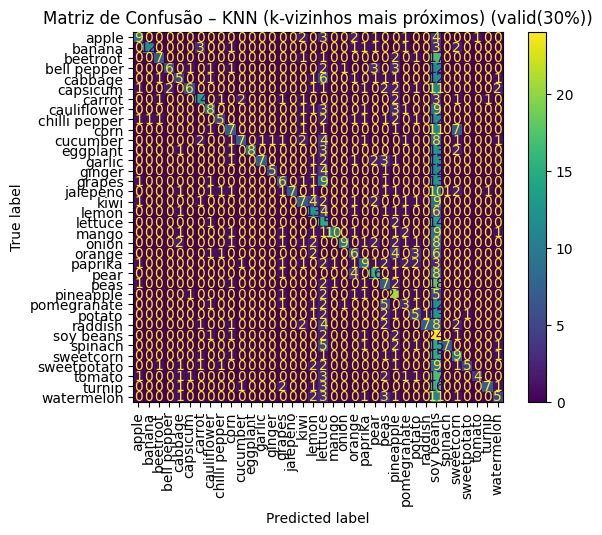


=== Árvore de Decisão @ valid(30%) ===
Acurácia (accuracy): 0.2740
F1-macro: 0.2760

Relatório de classificação (classification report):
               precision    recall  f1-score   support

        apple       0.24      0.26      0.25        23
       banana       0.48      0.44      0.46        25
     beetroot       0.27      0.31      0.29        29
  bell pepper       0.37      0.37      0.37        30
      cabbage       0.13      0.13      0.13        31
     capsicum       0.38      0.30      0.33        30
       carrot       0.46      0.44      0.45        27
  cauliflower       0.38      0.33      0.35        27
chilli pepper       0.10      0.10      0.10        29
         corn       0.22      0.24      0.23        29
     cucumber       0.35      0.29      0.32        31
     eggplant       0.32      0.29      0.30        28
       garlic       0.36      0.29      0.32        31
       ginger       0.25      0.26      0.26        23
       grapes       0.35      0.36  

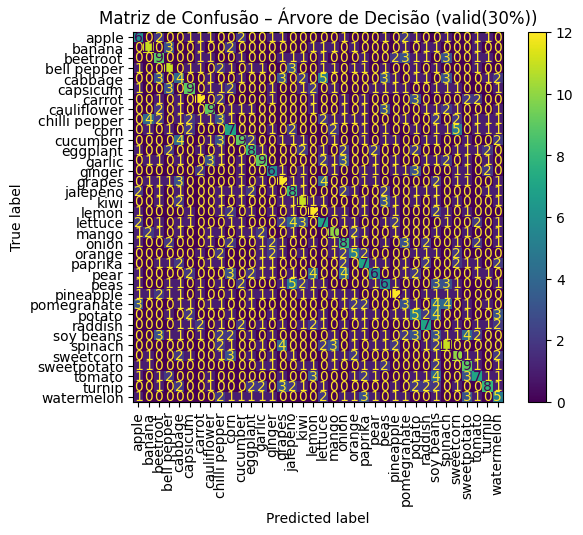


=== Regressão Logística @ valid(30%) ===
Acurácia (accuracy): 0.3125
F1-macro: 0.3101

Relatório de classificação (classification report):
               precision    recall  f1-score   support

        apple       0.39      0.57      0.46        23
       banana       0.39      0.52      0.45        25
     beetroot       0.35      0.28      0.31        29
  bell pepper       0.39      0.23      0.29        30
      cabbage       0.25      0.29      0.27        31
     capsicum       0.30      0.20      0.24        30
       carrot       0.38      0.37      0.38        27
  cauliflower       0.38      0.48      0.43        27
chilli pepper       0.21      0.14      0.17        29
         corn       0.25      0.28      0.26        29
     cucumber       0.26      0.35      0.30        31
     eggplant       0.32      0.43      0.37        28
       garlic       0.23      0.29      0.26        31
       ginger       0.25      0.22      0.23        23
       grapes       0.30      0.27

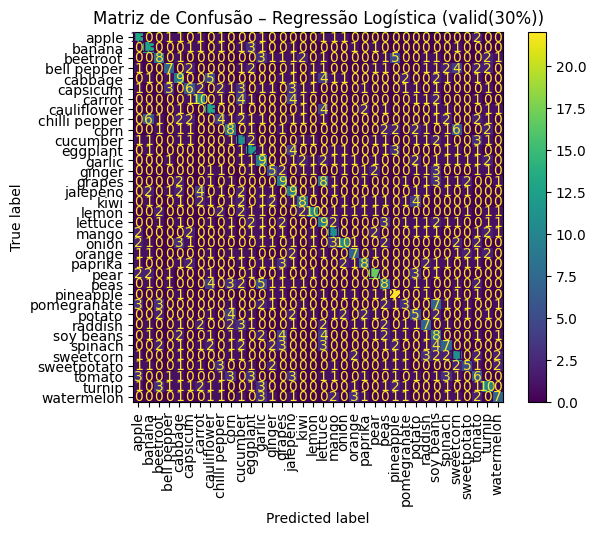


=== Random Forest (floresta aleatória) @ valid(30%) ===
Acurácia (accuracy): 0.3173
F1-macro: 0.3213

Relatório de classificação (classification report):
               precision    recall  f1-score   support

        apple       0.53      0.43      0.48        23
       banana       0.50      0.56      0.53        25
     beetroot       0.30      0.28      0.29        29
  bell pepper       0.32      0.27      0.29        30
      cabbage       0.24      0.26      0.25        31
     capsicum       0.23      0.20      0.21        30
       carrot       0.47      0.63      0.54        27
  cauliflower       0.35      0.41      0.38        27
chilli pepper       0.25      0.10      0.15        29
         corn       0.22      0.28      0.25        29
     cucumber       0.48      0.39      0.43        31
     eggplant       0.19      0.39      0.26        28
       garlic       0.28      0.26      0.27        31
       ginger       1.00      0.22      0.36        23
       grapes      

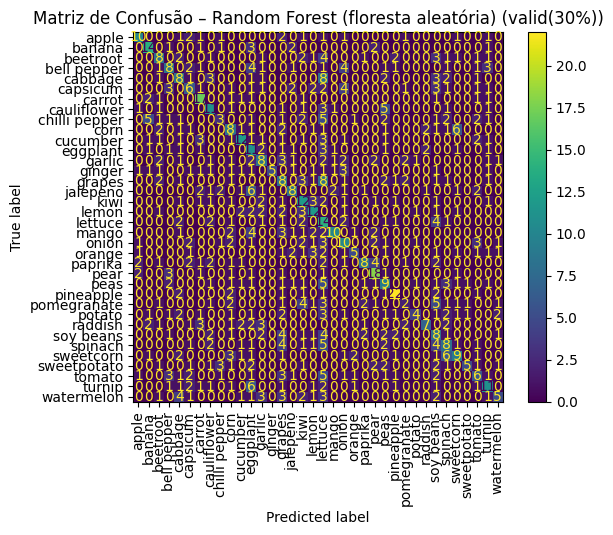


=== Bagging (agregação por bootstrap) @ valid(30%) ===
Acurácia (accuracy): 0.3308
F1-macro: 0.3291

Relatório de classificação (classification report):
               precision    recall  f1-score   support

        apple       0.42      0.35      0.38        23
       banana       0.43      0.52      0.47        25
     beetroot       0.31      0.34      0.33        29
  bell pepper       0.35      0.20      0.26        30
      cabbage       0.20      0.23      0.21        31
     capsicum       0.29      0.23      0.26        30
       carrot       0.46      0.67      0.55        27
  cauliflower       0.26      0.30      0.28        27
chilli pepper       0.27      0.14      0.18        29
         corn       0.39      0.24      0.30        29
     cucumber       0.54      0.42      0.47        31
     eggplant       0.23      0.39      0.29        28
       garlic       0.30      0.29      0.30        31
       ginger       0.29      0.22      0.25        23
       grapes       

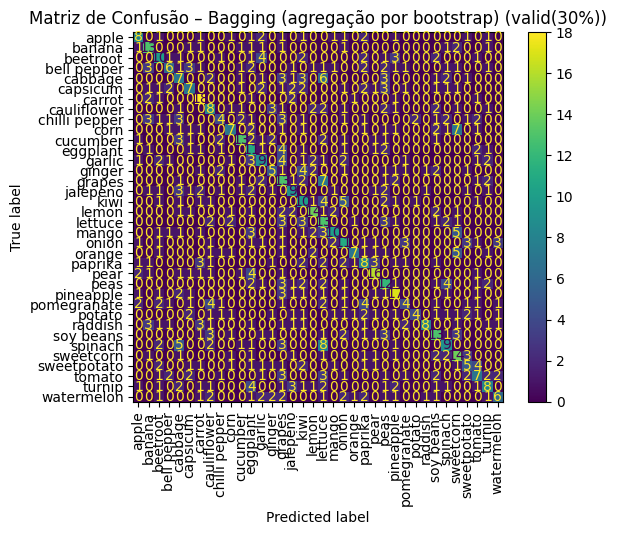


=== Boosting (AdaBoost) @ valid(30%) ===
Acurácia (accuracy): 0.1385
F1-macro: 0.1374

Relatório de classificação (classification report):
               precision    recall  f1-score   support

        apple       0.25      0.22      0.23        23
       banana       0.64      0.28      0.39        25
     beetroot       0.14      0.10      0.12        29
  bell pepper       0.14      0.07      0.09        30
      cabbage       0.14      0.06      0.09        31
     capsicum       0.11      0.20      0.14        30
       carrot       0.24      0.15      0.18        27
  cauliflower       0.10      0.11      0.11        27
chilli pepper       0.00      0.00      0.00        29
         corn       0.00      0.00      0.00        29
     cucumber       0.12      0.03      0.05        31
     eggplant       0.10      0.14      0.11        28
       garlic       0.42      0.16      0.23        31
       ginger       0.12      0.13      0.12        23
       grapes       0.04      0.03

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


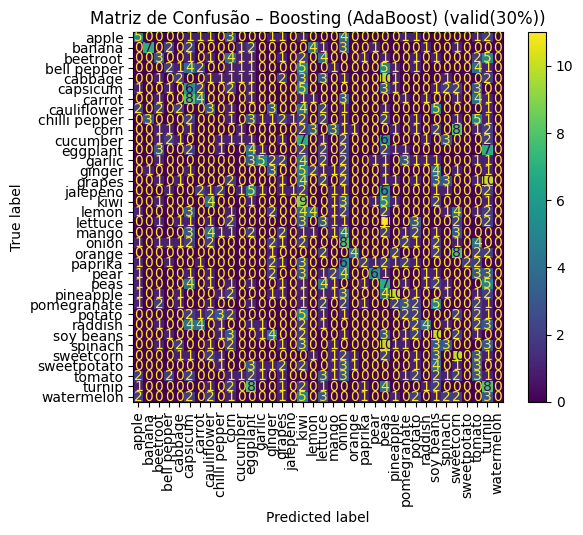


=== MLP (rede neural multicamada) @ valid(30%) ===
Acurácia (accuracy): 0.3087
F1-macro: 0.3095

Relatório de classificação (classification report):
               precision    recall  f1-score   support

        apple       0.38      0.35      0.36        23
       banana       0.74      0.56      0.64        25
     beetroot       0.32      0.28      0.30        29
  bell pepper       0.32      0.27      0.29        30
      cabbage       0.25      0.26      0.25        31
     capsicum       0.31      0.27      0.29        30
       carrot       0.43      0.48      0.46        27
  cauliflower       0.33      0.41      0.37        27
chilli pepper       0.29      0.21      0.24        29
         corn       0.24      0.24      0.24        29
     cucumber       0.27      0.39      0.32        31
     eggplant       0.31      0.39      0.34        28
       garlic       0.25      0.32      0.28        31
       ginger       0.22      0.22      0.22        23
       grapes       0.33

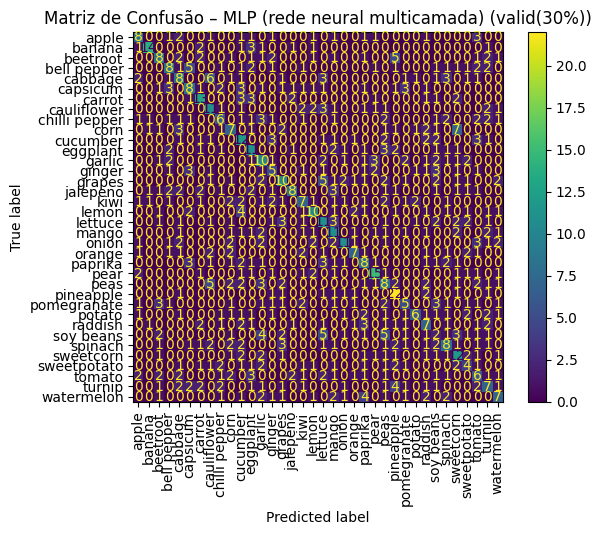


=== KNN (k-vizinhos mais próximos) @ test externo ===
Acurácia (accuracy): 0.9331
F1-macro: 0.9387

Relatório de classificação (classification report):
               precision    recall  f1-score   support

        apple       1.00      1.00      1.00        10
       banana       1.00      0.89      0.94         9
     beetroot       1.00      0.90      0.95        10
  bell pepper       0.90      0.90      0.90        10
      cabbage       1.00      1.00      1.00        10
     capsicum       1.00      0.90      0.95        10
       carrot       1.00      1.00      1.00        10
  cauliflower       1.00      1.00      1.00        10
chilli pepper       1.00      0.90      0.95        10
         corn       1.00      0.80      0.89        10
     cucumber       1.00      1.00      1.00        10
     eggplant       1.00      0.90      0.95        10
       garlic       1.00      1.00      1.00        10
       ginger       1.00      0.90      0.95        10
       grapes       1

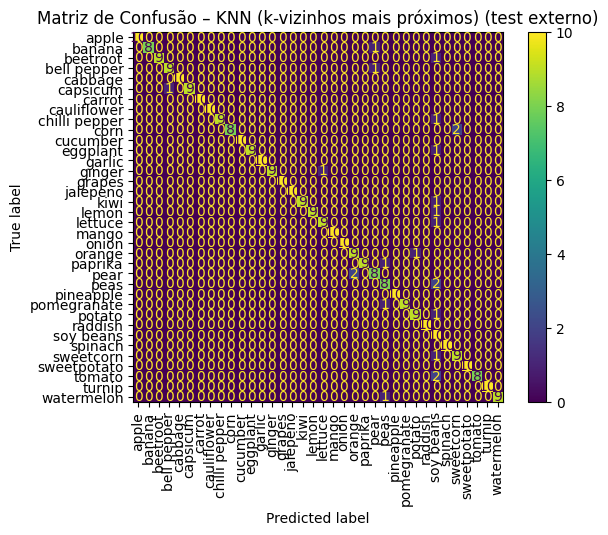


=== Árvore de Decisão @ test externo ===
Acurácia (accuracy): 0.9331
F1-macro: 0.9337

Relatório de classificação (classification report):
               precision    recall  f1-score   support

        apple       1.00      1.00      1.00        10
       banana       1.00      0.89      0.94         9
     beetroot       0.90      0.90      0.90        10
  bell pepper       0.83      1.00      0.91        10
      cabbage       0.83      1.00      0.91        10
     capsicum       0.90      0.90      0.90        10
       carrot       0.91      1.00      0.95        10
  cauliflower       1.00      1.00      1.00        10
chilli pepper       1.00      0.90      0.95        10
         corn       1.00      0.80      0.89        10
     cucumber       0.91      1.00      0.95        10
     eggplant       1.00      0.90      0.95        10
       garlic       1.00      1.00      1.00        10
       ginger       1.00      0.90      0.95        10
       grapes       1.00      1.00

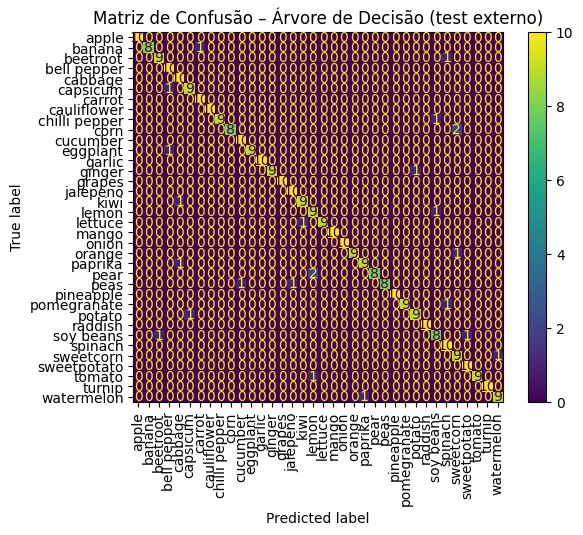


=== Regressão Logística @ test externo ===
Acurácia (accuracy): 0.9415
F1-macro: 0.9418

Relatório de classificação (classification report):
               precision    recall  f1-score   support

        apple       1.00      1.00      1.00        10
       banana       0.90      1.00      0.95         9
     beetroot       0.90      0.90      0.90        10
  bell pepper       0.90      0.90      0.90        10
      cabbage       1.00      1.00      1.00        10
     capsicum       1.00      0.90      0.95        10
       carrot       1.00      1.00      1.00        10
  cauliflower       0.91      1.00      0.95        10
chilli pepper       1.00      0.90      0.95        10
         corn       0.89      0.80      0.84        10
     cucumber       0.91      1.00      0.95        10
     eggplant       0.90      0.90      0.90        10
       garlic       0.83      1.00      0.91        10
       ginger       1.00      0.90      0.95        10
       grapes       0.83      1.

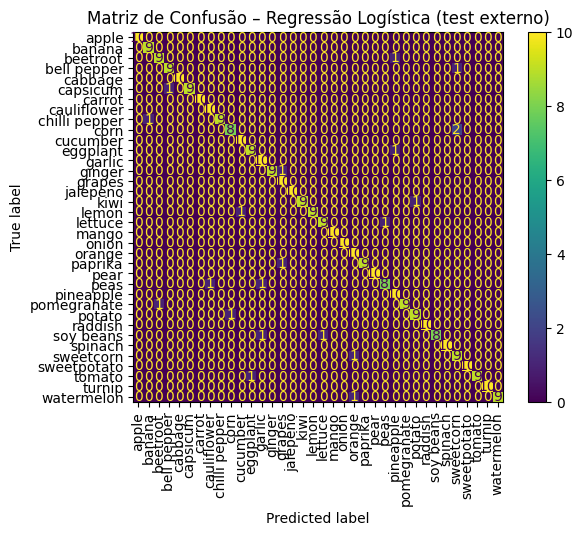


=== Random Forest (floresta aleatória) @ test externo ===
Acurácia (accuracy): 0.9387
F1-macro: 0.9396

Relatório de classificação (classification report):
               precision    recall  f1-score   support

        apple       1.00      1.00      1.00        10
       banana       0.90      1.00      0.95         9
     beetroot       1.00      0.90      0.95        10
  bell pepper       0.75      0.90      0.82        10
      cabbage       0.83      1.00      0.91        10
     capsicum       1.00      0.90      0.95        10
       carrot       1.00      1.00      1.00        10
  cauliflower       1.00      1.00      1.00        10
chilli pepper       1.00      0.90      0.95        10
         corn       1.00      0.80      0.89        10
     cucumber       0.91      1.00      0.95        10
     eggplant       1.00      0.90      0.95        10
       garlic       0.91      1.00      0.95        10
       ginger       1.00      0.90      0.95        10
       grapes    

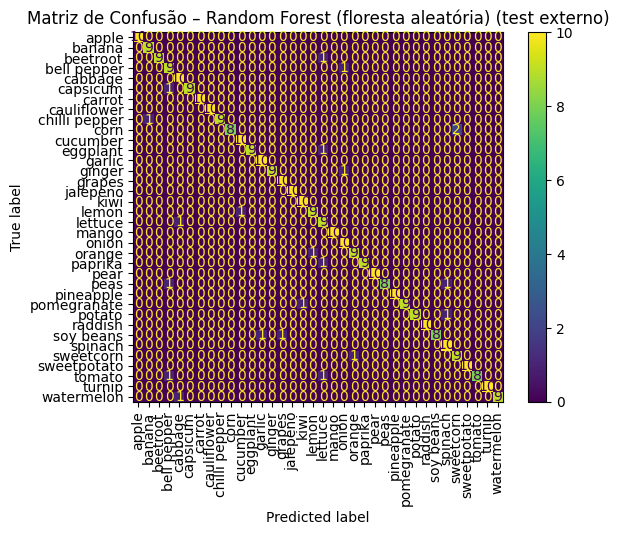


=== Bagging (agregação por bootstrap) @ test externo ===
Acurácia (accuracy): 0.9415
F1-macro: 0.9418

Relatório de classificação (classification report):
               precision    recall  f1-score   support

        apple       0.91      1.00      0.95        10
       banana       0.89      0.89      0.89         9
     beetroot       1.00      0.90      0.95        10
  bell pepper       0.82      0.90      0.86        10
      cabbage       1.00      1.00      1.00        10
     capsicum       0.90      0.90      0.90        10
       carrot       1.00      1.00      1.00        10
  cauliflower       0.91      1.00      0.95        10
chilli pepper       1.00      0.90      0.95        10
         corn       0.89      0.80      0.84        10
     cucumber       1.00      1.00      1.00        10
     eggplant       1.00      0.90      0.95        10
       garlic       0.83      1.00      0.91        10
       ginger       1.00      0.90      0.95        10
       grapes     

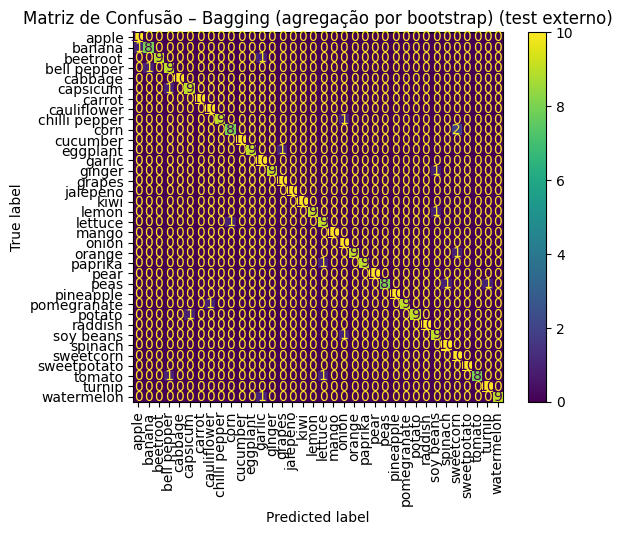


=== Boosting (AdaBoost) @ test externo ===
Acurácia (accuracy): 0.3426
F1-macro: 0.3474

Relatório de classificação (classification report):
               precision    recall  f1-score   support

        apple       0.67      0.20      0.31        10
       banana       1.00      0.56      0.71         9
     beetroot       0.33      0.30      0.32        10
  bell pepper       0.55      0.60      0.57        10
      cabbage       0.75      0.60      0.67        10
     capsicum       0.32      0.60      0.41        10
       carrot       0.80      0.40      0.53        10
  cauliflower       0.00      0.00      0.00        10
chilli pepper       0.27      0.30      0.29        10
         corn       0.00      0.00      0.00        10
     cucumber       0.80      0.40      0.53        10
     eggplant       0.45      0.50      0.48        10
       garlic       0.67      0.40      0.50        10
       ginger       0.27      0.30      0.29        10
       grapes       0.00      0.

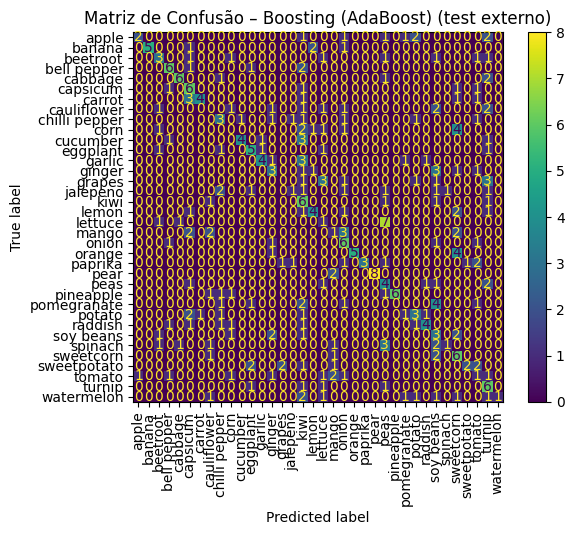


=== MLP (rede neural multicamada) @ test externo ===
Acurácia (accuracy): 0.9415
F1-macro: 0.9420

Relatório de classificação (classification report):
               precision    recall  f1-score   support

        apple       1.00      1.00      1.00        10
       banana       1.00      1.00      1.00         9
     beetroot       0.90      0.90      0.90        10
  bell pepper       0.82      0.90      0.86        10
      cabbage       1.00      1.00      1.00        10
     capsicum       0.82      0.90      0.86        10
       carrot       1.00      1.00      1.00        10
  cauliflower       0.91      1.00      0.95        10
chilli pepper       1.00      0.90      0.95        10
         corn       1.00      0.80      0.89        10
     cucumber       0.91      1.00      0.95        10
     eggplant       0.90      0.90      0.90        10
       garlic       0.83      1.00      0.91        10
       ginger       1.00      0.90      0.95        10
       grapes       1.

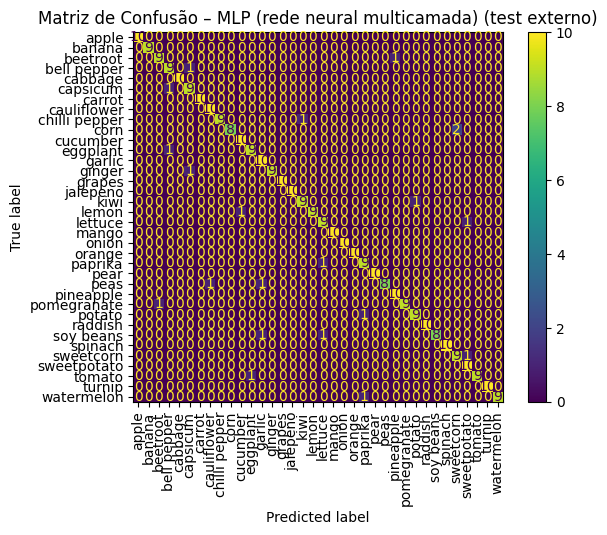


=== Tabela de validação (30%) ===


,acc_valid,f1_valid
KNN (k-vizinhos mais próximos),0.296154,0.339661
Bagging (agregação por bootstrap),0.330769,0.329090
Random Forest (floresta aleatória),0.317308,0.321252
Regressão Logística,0.312500,0.310076
MLP (rede neural multicamada),0.308654,0.309495
Árvore de Decisão,0.274038,0.275993
Boosting (AdaBoost),0.138462,0.137366



=== Tabela de teste externo ===


,acc_test,f1_test
MLP (rede neural multicamada),0.941504,0.941998
Regressão Logística,0.941504,0.941836
Bagging (agregação por bootstrap),0.941504,0.941765
Random Forest (floresta aleatória),0.938719,0.939555
KNN (k-vizinhos mais próximos),0.933148,0.938717
Árvore de Decisão,0.933148,0.933683
Boosting (AdaBoost),0.342618,0.347365


In [ ]:

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_validate
import numpy as np, pandas as pd, matplotlib.pyplot as plt

def evaluate_split(name, clf, X, y, split_name):
    y_hat = clf.predict(X)
    acc = accuracy_score(y, y_hat)
    f1m = f1_score(y, y_hat, average='macro')
    print(f"\n=== {name} @ {split_name} ===")
    print("Acurácia (accuracy):", f"{acc:.4f}")
    print("F1-macro:", f"{f1m:.4f}")
    print("\nRelatório de classificação (classification report):")
    print(classification_report(y, y_hat))
    cm = confusion_matrix(y, y_hat, labels=np.unique(y))
    ConfusionMatrixDisplay(cm, display_labels=np.unique(y)).plot(xticks_rotation=90)
    plt.title(f"Matriz de Confusão – {name} ({split_name})")
    plt.show()
    return acc, f1m

results_valid = {}
for name, clf in fitted.items():
    acc, f1m = evaluate_split(name, clf, X_valid, y_valid, "valid(30%)")
    results_valid[name] = {"acc_valid": acc, "f1_valid": f1m}

results_test = {}
if 'X_test_ext' in globals() and X_test_ext is not None and y_test_ext is not None:
    for name, clf in fitted.items():
        acc, f1m = evaluate_split(name, clf, X_test_ext, y_test_ext, "test externo")
        results_test[name] = {"acc_test": acc, "f1_test": f1m}

print("\n=== Tabela de validação (30%) ===")
df_valid = pd.DataFrame(results_valid).T.sort_values(by=["f1_valid","acc_valid"], ascending=False)
display(df_valid)

if results_test:
    print("\n=== Tabela de teste externo ===")
    df_test = pd.DataFrame(results_test).T.sort_values(by=["f1_test","acc_test"], ascending=False)
    display(df_test)

from numpy import vstack, hstack
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"accuracy":"accuracy", "f1_macro":"f1_macro"}
cv_table = {}
for name, clf in models.items():
    scores = cross_validate(clf, vstack([X_train, X_valid]), hstack([y_train, y_valid]),
                            cv=cv, scoring=scoring, n_jobs=-1, error_score='raise')
    cv_table[name] = {
        "acc_mean": scores["test_accuracy"].mean(),
        "acc_std":  scores["test_accuracy"].std(),
        "f1_mean":  scores["test_f1_macro"].mean(),
        "f1_std":   scores["test_f1_macro"].std()
    }

df_cv = pd.DataFrame(cv_table).T.sort_values(by=["f1_mean","acc_mean"], ascending=False)
display(df_cv)



## 5. Empacotamento do melhor modelo e *stub* de aplicativo Streamlit

Para implantação simples, recomenda-se salvar o **normalizador** (*scaler*) e o **melhor modelo** (critério por F1-macro) usando `joblib`. O *stub* do Streamlit ilustra o fluxo **upload → extração de atributos → predição**.


In [ ]:
# @title Seleção do melhor modelo (F1-macro) e salvamento no Google Drive
import joblib, os

# Determina o melhor modelo com base no F1 da validação
best_name = max(results_valid, key=lambda k: results_valid[k]["f1_valid"])
best_model = fitted[best_name]
print("Melhor modelo (validação F1-macro):", best_name, "->", results_valid[best_name])

# Caminho alvo no Google Drive
drive_path = "/content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/models"
os.makedirs(drive_path, exist_ok=True)

# Caminhos completos de destino
scaler_path = os.path.join(drive_path, "scaler.joblib")
model_path = os.path.join(drive_path, "best_model.joblib")

# Salvamento dos artefatos
joblib.dump(scaler, scaler_path)
joblib.dump(best_model, model_path)

print(f"✅ Artefatos salvos com sucesso em:\n{drive_path}")



In [ ]:
# @title Verificação dos arquivos no Google Drive
import os

drive_path = "/content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/models"
for f in os.listdir(drive_path):
    print("📄", f, f"({os.path.getsize(os.path.join(drive_path, f))/1024:.1f} KB)")


In [ ]:

# app_streamlit_stub.py
import streamlit as st
import numpy as np, cv2
from PIL import Image
import joblib
from skimage.feature import hog

st.title("Classificador de Frutas, Legumes e Verduras 🍎🥕")

scaler = joblib.load("models/scaler.joblib")
model  = joblib.load("models/best_model.joblib")

def rgb_mean_feature(img):
    return img.mean(axis=(0,1))

def hog_feature(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    feat = hog(
        gray, orientations=9,
        pixels_per_cell=(8,8),
        cells_per_block=(2,2),
        block_norm='L2-Hys', transform_sqrt=True, feature_vector=True
    )
    return feat

uploaded = st.file_uploader("Envie uma imagem (.jpg/.png)", type=["jpg","jpeg","png"])
if uploaded:
    pil = Image.open(uploaded).convert("RGB")
    img = np.array(pil)
    img_resized = cv2.resize(img, (128, 128))
    f_rgb = rgb_mean_feature(img_resized)
    f_hog = hog_feature(img_resized)
    feats = np.hstack([f_rgb, f_hog]).reshape(1, -1)
    feats = scaler.transform(feats)
    pred = model.predict(feats)[0]
    st.image(pil, caption=f"Predição: {pred}", use_container_width=True)



## 6. Conclusões, *trade-offs* (compensações) e trabalhos futuros

- **KNN (k-vizinhos mais próximos):** interpretação simples; custo de predição cresce com amostra; sensível à escala.  
- **Árvore de Decisão:** interpretável; risco de sobreajuste (*overfitting*) isolada.  
- **Regressão Logística:** baseline competitivo para multiclasse; requer atributos informativos.  
- **Random Forest (floresta aleatória):** robusta; bom desempenho geral; menos interpretável que árvore única.  
- **Bagging (agregação por *bootstrap*):** reduz variância; favorece estimadores instáveis.  
- **Boosting (AdaBoost):** corrige erros sequenciais; sensível a ruído e hiperparâmetros.  
- **MLP (rede neural multicamada):** modela não linearidades; demanda ajuste fino e, por vezes, mais dados.

**Futuros:** *data augmentation*, PCA, calibração de probabilidades e exploração de CNN em trabalho posterior.



## 7. Referências

- Kelleher, J. D.; Mac Namee, B.; D’Arcy, A. (2020). *Fundamentals of Machine Learning for Predictive Data Analytics (2nd ed.).* MIT Press.  
- Documentação do scikit-learn e scikit-image.
